In [1]:
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt
import skimage

sys.path.append("../")
import src.plot as myplot
import seaborn as sns

import sklearn

In [2]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/0_classifier/paper_plots/../src/plot.py'>

In [24]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/0_classifier/paper_plots/../src/paper_utils.py'>

In [4]:
sample_sizes = [10, 100, 500,1000, 2000, 3000,4000,5000]
sample_sizes = [500]
counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, letter="", path_format="../Output/sample_sizes")


In [5]:
test_mcms, test_probs = utils.get_complete_testprobs(mcms_samplesizes,counts_samplesizes,sample_sizes,n_runs=2,smooth=True)

# Find indicative ICC

In [132]:
digit_pair = [5,3]
mcm_idx = 5
sample_idx = 0
run_idx = 0
dist_map, comms, icc_data = utils.distmap_from_testprobs(test_probs, test_mcms, digit_pair, mcm_idx, sample_idx,run_idx, return_comms=True, return_iccdata=True)
dists = np.unique(dist_map)

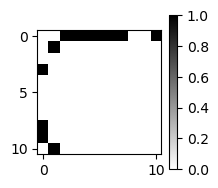

In [133]:
def plot_top_k(dist_map, k):
    arr = dist_map.copy()
    mi = np.unique(arr)
    mi = np.sort(mi)[::-1]

    arr[arr < mi[k]] = 0
    arr[~(arr < mi[k])] = 1

    plt.imshow(arr, cmap="binary")
    plt.colorbar()
plt.figure(figsize=(2,2))
# plot_top_k(dist_map, 15)
plot_top_k(dist_map, 4)

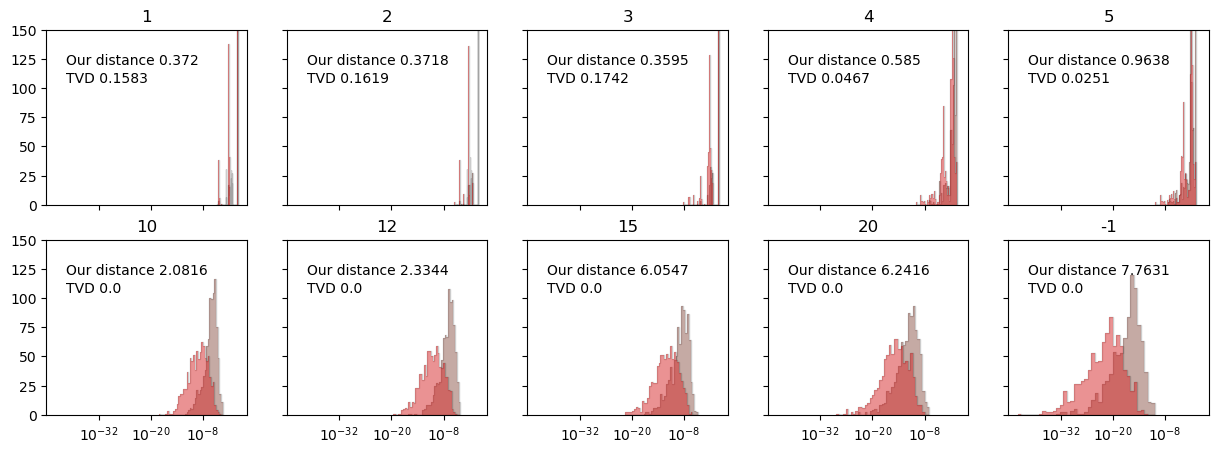

In [134]:
# TOP K ICC
top_ks = [1,2,3,4,5,
          10,12,15,20,-1]

ord_distidcs = np.argsort(dists)[::-1]

fig, axs = plt.subplots(2,5, sharex = True, sharey=True,figsize=(15,5))
seedigits = digit_pair
axs = np.ravel(axs)
colors = myplot.get_list_fromcmap("tab10", N=10)
by_k = np.cumprod(icc_data[ord_distidcs],axis=0)[:,:,seedigits]

for i, ax in enumerate(axs):
    data = by_k[top_ks[i],...]
    logbins = np.geomspace(data[data != -1].min(),data.max(), 40)

    for idx, dig in enumerate(seedigits):
        ax.hist(data[:,idx],bins=logbins, facecolor="None",alpha=.2,edgecolor="black",histtype= "stepfilled")
        ax.hist(data[:,idx],bins=logbins, label=f'Top k={top_ks[i]} indicative icc',alpha=.5,histtype= "stepfilled",facecolor=colors[dig])

    ax.text(.1,.8,f"Our distance {utils.norm_distribution_distance(data[:,0],data[:,1]).round(4)}", transform=ax.transAxes)
    ax.text(.1,.7,f"TVD {utils.total_variation_distance(data[:,0],data[:,1]).round(4)}", transform=ax.transAxes)

    ax.set_title(top_ks[i])
    ax.set_xscale("log")
    ax.set_ylim((0,150))

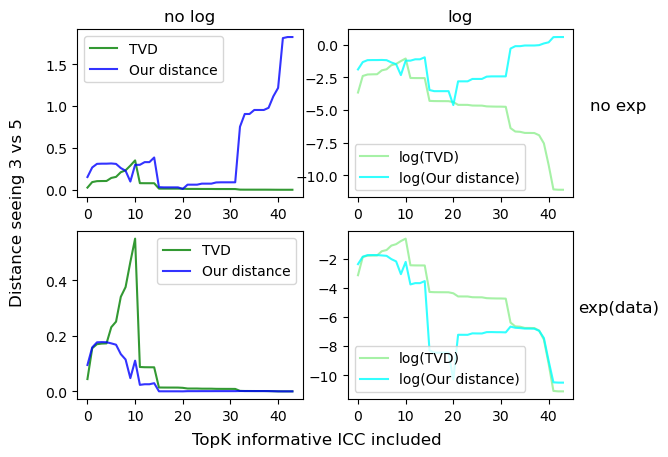

In [119]:
# distances over k
inp = by_k.copy()

fig, axs = plt.subplots(2,2)
axs = np.ravel(axs)

inp = by_k.copy()
tvds = np.array([utils.total_variation_distance(d[:, 0],d[:, 1]) for d in inp])
norm_dists = np.array([utils.norm_distribution_distance(d[:, 0], d[:, 1]) for d in inp])

axs[0].plot(tvds, label="TVD", color="green",alpha=.8)     
axs[0].plot(norm_dists, label="Our distance", color="blue",alpha=.8)
axs[0].legend()
axs[0].set_title("no log")


axs[1].plot(np.log(tvds), label="log(TVD)", color="lightgreen",alpha=.8)
axs[1].plot(np.log(norm_dists), label="log(Our distance)",color="cyan",alpha=.8)
axs[1].legend()
axs[1].set_title("log")

inp = by_k.copy()
inp = np.exp(by_k)
tvds = np.array([utils.total_variation_distance(d[:, 0],d[:, 1]) for d in inp])
norm_dists = np.array([utils.norm_distribution_distance(d[:, 0], d[:, 1]) for d in inp])

axs[2].plot(tvds, label="TVD", color="green",alpha=.8)     
axs[2].plot(norm_dists, label="Our distance", color="blue",alpha=.8)
axs[2].legend()



axs[3].plot(np.log(tvds), label="log(TVD)", color="lightgreen",alpha=.8)
axs[3].plot(np.log(norm_dists), label="log(Our distance)",color="cyan",alpha=.8)
axs[3].legend()


axs[1].set_ylabel("no exp", rotation=0, size='large')
axs[1].yaxis.set_label_coords(1.2,.5)
axs[3].set_ylabel("exp(data)", rotation=0, size='large')
axs[3].yaxis.set_label_coords(1.2,.5)

fig.supxlabel("TopK informative ICC included")
fig.supylabel("Distance seeing 3 vs 5")
# plt.yscale("log")
plt.legend()


---------------







---------------

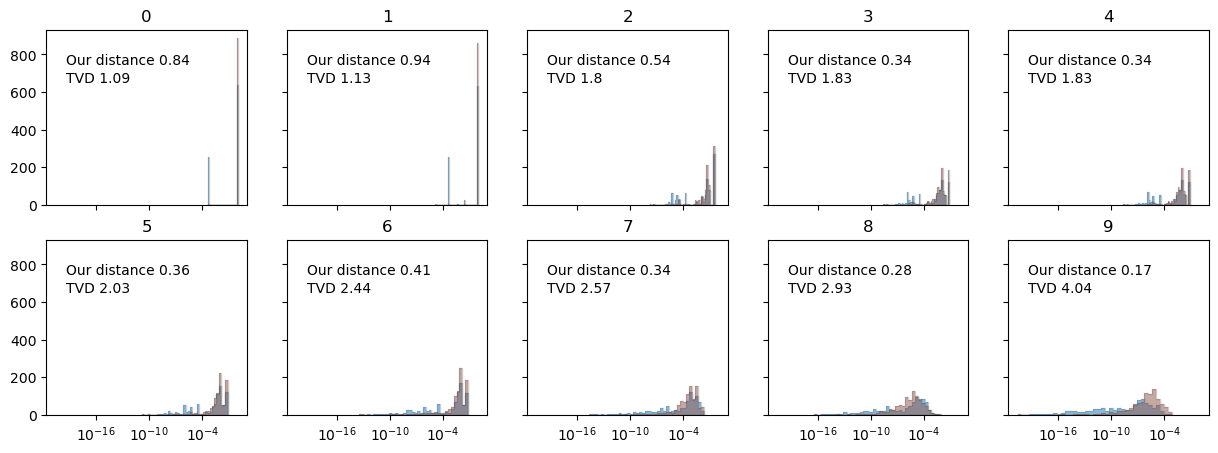

In [34]:
# TOP K ICC
fig, axs = plt.subplots(2,5, sharex = True, sharey=True,figsize=(15,5))
seedigits = [0,5]
axs = np.ravel(axs)
colors = myplot.get_list_fromcmap("tab10", N=10)
by_k = np.cumprod(icc_data[np.argsort(dists)],axis=0)[:,:,seedigits]

for i, ax in enumerate(axs):
    data = by_k[i,...]
    logbins = np.geomspace(data[data != -1].min(),data.max(), 40)

    for idx, dig in enumerate(seedigits):
        ax.hist(data[:,idx],bins=logbins, facecolor="None",alpha=.2,edgecolor="black",histtype= "stepfilled")
        ax.hist(data[:,idx],bins=logbins, label=f'Top k={top_k} indicative icc',alpha=.5,histtype= "stepfilled",facecolor=colors[dig])
    ax.text(.1,.8,f"Our distance {utils.norm_distribution_distance(np.log(data[:,0]),np.log(data[:,1])).round(2)}", transform=ax.transAxes)
    ax.text(.1,.7,f"TVD {utils.total_variation_distance(np.log(data[:,0]),np.log(data[:,1])).round(2)}", transform=ax.transAxes)

    ax.set_title(i)
    ax.set_xscale("log")



In [ ]:
# # find indicative icc based on test_probs
# mcm_idx = 3
# sample_idx = 0
# run = 0
# digit_pair = [3,5]
# # (nr_mcms, len(sample_sizes), n_runs | nr_digits,maxnr_icc, len(utils.load_test_data(digit=0))))
# # (nr_mcms, len(sample_sizes), n_runs, | nr_digits,maxnr_icc), fill_value="", dtype="<U121")

# icc_data = test_probs[mcm_idx,sample_idx, run]
# print(icc_data.shape)
# # get into format for decision boundary distance function
# nr_icc = np.argmin(icc_data != -1, axis =1)[0,0] # remove icc rows of surplus icc, all the same
# icc_data = icc_data[:,:nr_icc,:]
# icc_data = np.transpose(icc_data, (1, 2, 0))
# print(icc_data.shape)
# avg_icc_prob = icc_data.mean(axis=1)
# dists = utils.normalised_signed_distance_decisionbound(avg_icc_prob,digit_pair[0],digit_pair[1])
# # find mcm and build map
# intr_mcm = test_mcms[mcm_idx,sample_idx, run][mcm_idx,:nr_icc]
# comms = myplot.generate_icc_comms_map(intr_mcm)
# dist_map = dists[comms] # plt.scatter(avg_prob[:,cat_a], avg_prob[:,cat_b])
# # plt.imshow(dist_map)
# # plt.colorbar()
# plt.scatter(avg_icc_prob[:,digit_pair[0]], avg_icc_prob[:, digit_pair[1]])

In [ ]:
# def distmap_from_testprobs(test_probs,test_mcms,digit_pair, mcm_idx, sample_idx, run_idx, return_comms = False):

#     icc_data = test_probs[mcm_idx,sample_idx, run_idx]

#     # get into format for decision boundary distance function
#     nr_icc = np.argmin(icc_data != -1, axis =1)[0,0] # remove icc rows of surplus icc, all the same
#     icc_data = icc_data[:,:nr_icc,:]
#     icc_data = np.transpose(icc_data, (1, 2, 0)) 
#     avg_icc_prob = icc_data.mean(axis=1) # over test samples
#     dists = utils.normalised_signed_distance_decisionbound(avg_icc_prob,digit_pair[0],digit_pair[1])
#     # find mcm and build map
#     intr_mcm = test_mcms[mcm_idx,sample_idx, run_idx][0,:nr_icc] # get rid of unused rows, mcm_identical for every icc
#     comms = myplot.generate_icc_comms_map(intr_mcm)
#     dist_map = dists[comms] 
#     # plt.scatter(avg_prob[:,cat_a], avg_prob[:,cat_b])
#     # plt.imshow(dist_map)
#     if return_comms:
#         return dist_map, comms
#     else: 
#         return dist_map

In [ ]:
vfunc = np.vectorize(utils.total_variation_distance)
result = vfunc(np.log(by_k[:, :, 0].T), np.log(by_k[:, :, 1].T)).round(2)

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
(33, 892, 2)


utils.total_variation_distance(np.log(by_k[:,:,0]),np.log(by_k[:,:,1])).round(2).shape

TypeError: object of type 'numpy.float64' has no len()

TypeError: cannot unpack non-iterable int object

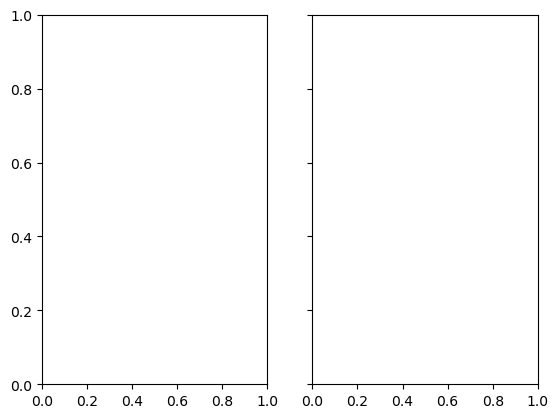

In [ ]:
# TOP K ICC
top_k = 5
fig, axs = plt.subplots(1,2, sharex = True, sharey=True)
seedigits = [3,5]
ax = axs[0]
colors = myplot.get_list_fromcmap("tab10", N=10)

by_k = np.comprod(icc_data[np.argsort(dists)])
data = icc_data[np.argsort(dists)[:top_k]].prod(axis=0)[:,seedigits].T
logbins = np.geomspace(data[data != -1].min(),data.max(), 40)

for idx, dig in seedigits:

    ax.hist(data[:,idx],bins=logbins, facecolor="None",alpha=.2,edgecolor="black",histtype= "stepfilled")
    ax.hist(data[:,idx],bins=logbins, label=f'Top k={top_k} indicative icc',alpha=.5,histtype= "stepfilled",facecolor=colors[dig])
# for 
# plt.hist(data,bins=logbins) # instead of single ones select top K icc, see difference then when multiply them

# plt.xscale("log")


In [ ]:
# nr_icc = np.argwhere(test_mcms[mcm_idx,sample_idx, run] == "").min(axis=0)[1]

33

In [ ]:
samples_path = "../OUTPUT/sample_sizes"
mcms_fname = "MCMs_0.json"
counts_fname = "Counts_0.json"
n_samples = sample_sizes[sample_sizes.index(500)] # FIXME 

with open(os.path.join(samples_path,str(n_samples),"MCMs", mcms_fname), "r") as f:
        all_MCM = [np.array(i) for i in json.load(f)] 


with open(os.path.join(samples_path,str(n_samples),"Counts", counts_fname), "r") as f:
        C = json.load(f)
mcm_index = 3

In [ ]:
n_variables = 121 #TODO This cell is not trash.
data_path = "../INPUT_all/data/"
data_filename_format = "train-images-unlabeled-{}.dat"
show_digit = 3

# # # for all images in all categories, get the PDF of that all ICC of one MCM fitted to one image
# all_C_icc_x = myplot.calculate_P_icc(C, all_MCM,show_digit,n_variables, data_path,data_filename_format)
# np.save(f"../OUTPUT/sample_sizes/{n_samples}/all_C_icc_{show_digit}.npy", all_C_icc_x)




In [ ]:
all_C_icc_x = np.load(f"../OUTPUT/sample_sizes/{n_samples}/all_C_icc_{show_digit}.npy")
mcm3_comms_map = myplot.generate_icc_comms_map(all_MCM[3])
mcm5_comms_map = myplot.generate_icc_comms_map(all_MCM[5])

In [ ]:
n_variables = 121
test_data_path = "../INPUT_all/data/testdata_separated"
test_data_filename_format = "test-images-unlabeled-{}.dat"
test_all_C_icc_3 = myplot.calculate_P_icc(C, all_MCM,3,n_variables, test_data_path,test_data_filename_format)


In [ ]:
cat_a = 3
cat_b = 5
mcm_idx = 3

all_prob = test_all_C_icc_3/all_C_icc_x.shape[1] # for MCM 0
avg_prob = all_prob.mean(axis=1)

comms3 = myplot.generate_icc_comms_map(all_MCM[3])
distances = utils.normalised_signed_distance_decisionbound(avg_prob, cat_a, cat_b)
dist_map = distances[comms3] # plt.scatter(avg_prob[:,cat_a], avg_prob[:,cat_b])

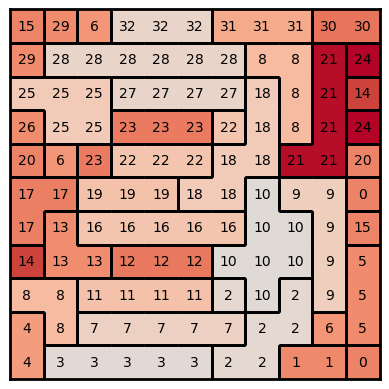

In [ ]:

informative_icc = np.argsort(avg_prob[cat_b,:])

im = myplot.partition_map(plt.gca(), dist_map,comms3,myplot.find_borders(comms3), cbar=False)

In [ ]:
# # slice informative icc / or plot all icc 3 vs 5 from MCM 3
# # only take first rank values
# test_probs[3,0,0,3,informative_icc[0]]

(array([ 42.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 850.]),
 array([0.00848303, 0.10189621, 0.19530938, 0.28872255, 0.38213573,
        0.4755489 , 0.56896208, 0.66237525, 0.75578842, 0.8492016 ,
        0.94261477]),
 <BarContainer object of 10 artists>)

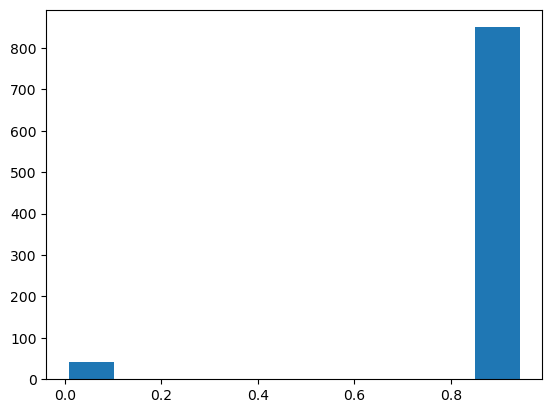

In [ ]:
#(nr_mcms, len(sample_sizes), n_runs,nr_digits,maxnr_icc, len(utils.load_test_data(digit=0))), fill_value=-1.0)

mcms_see_3 = test_probs[:,0,0,3,:] # need to get rid of the -1 

icc = 4
plt.hist(mcms_see_3[3,icc,:][mcms_see_3[3,icc,:] != -1]) 


In [ ]:
n_variables = 121 #TODO This cell is not trash.
data_path = "../INPUT_all/data/"
data_filename_format = "train-images-unlabeled-{}.dat"
show_digit = 3

# # # for all images in all categories, get the PDF of that all ICC of one MCM fitted to one image
# all_C_icc_x = myplot.calculate_P_icc(C, all_MCM,show_digit,n_variables, data_path,data_filename_format)
# np.save(f"../OUTPUT/sample_sizes/{n_samples}/all_C_icc_{show_digit}.npy", all_C_icc_x)




(array([ 57.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 835.]),
 array([2.49500998e-04, 9.30638723e-02, 1.85878244e-01, 2.78692615e-01,
        3.71506986e-01, 4.64321357e-01, 5.57135729e-01, 6.49950100e-01,
        7.42764471e-01, 8.35578842e-01, 9.28393214e-01]),
 <BarContainer object of 10 artists>)

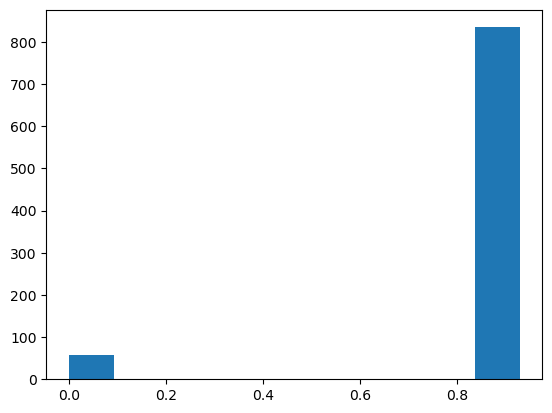

In [ ]:
plt.hist(icc_data[icc_data != -1])

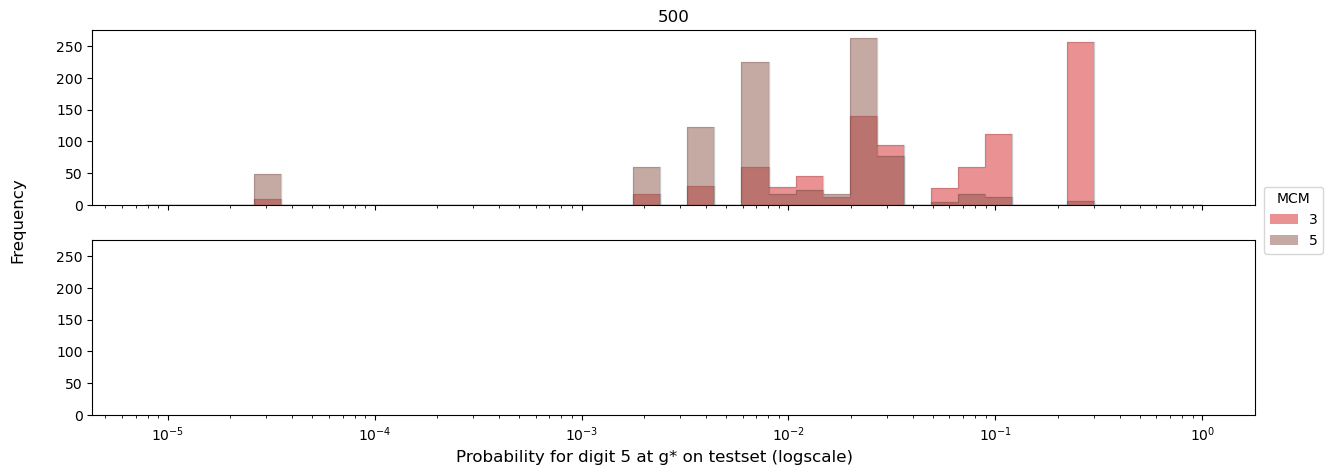

In [ ]:
def filter_mask(arr, cond):
    return arr[cond(arr)]

#(nr_mcms, len(sample_sizes), n_runs,nr_digits,maxnr_icc, len(utils.load_test_data(digit=0))), fill_value=-1.0)

seedigit = 5
run_idx = 0
mcm_idx = 3
icc_idx = 18
colors = myplot.get_list_fromcmap("tab10", N=10)
fig, axs = plt.subplots(2,(len(sample_sizes)+1)//2, figsize=(15,5),sharex=True, sharey=True)
axs = np.ravel(axs)
for ss_idx, sample_size in enumerate(sample_sizes):
    data = test_probs[:,ss_idx,run_idx,:] # get mcm, icc, samples
    ax = axs[ss_idx]
    logbins = np.geomspace(data[data != -1].min(),data.max(), 40)
    # logbins = np.linspace(data.min(),data.max(), 40)
    for seedigit in [3,5]:
        icc_data = data[mcm_idx, seedigit,icc_idx].T
        icc_data = icc_data[icc_data != -1]
        ax.hist(icc_data,bins=logbins, facecolor="None",alpha=.2,edgecolor="black",histtype= "stepfilled")
        ax.hist(icc_data,bins=logbins, label=f'{seedigit}',alpha=.5,histtype= "stepfilled",facecolor=colors[seedigit])

    # ax.text(.1,.8,f"Our distance {utils.norm_distribution_distance(np.log(test_probs[0,ss_idx,0, seedigit]),np.log(test_probs[1,ss_idx,0, seedigit])).round(2)}", transform=ax.transAxes)
    # ax.text(.1,.7,f"TVD {utils.total_variation_distance(np.log(test_probs[0,ss_idx,0, seedigit]),np.log(test_probs[1,ss_idx,0, seedigit])).round(2)}", transform=ax.transAxes)

    # if ss_idx == len(sample_sizes)-3:
    #     handles, labels = ax.get_legend_handles_labels()
    #     ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

    ax.set_title(sample_size)
    ax.set_xscale("log")

handles, labels = ax.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='center right', ncol=1,bbox_to_anchor=(.95,0.5)) #bbox_to_anchor=(.95,0.5)
leg.set_title("MCM",)

fig.supxlabel(f"Probability for digit {seedigit} at g* on testset (logscale)")

supylabel = fig.supylabel('Frequency')
supylabel.set_x(supylabel.get_position()[0] + 0.05)



plt.show()


